In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [3]:
# import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

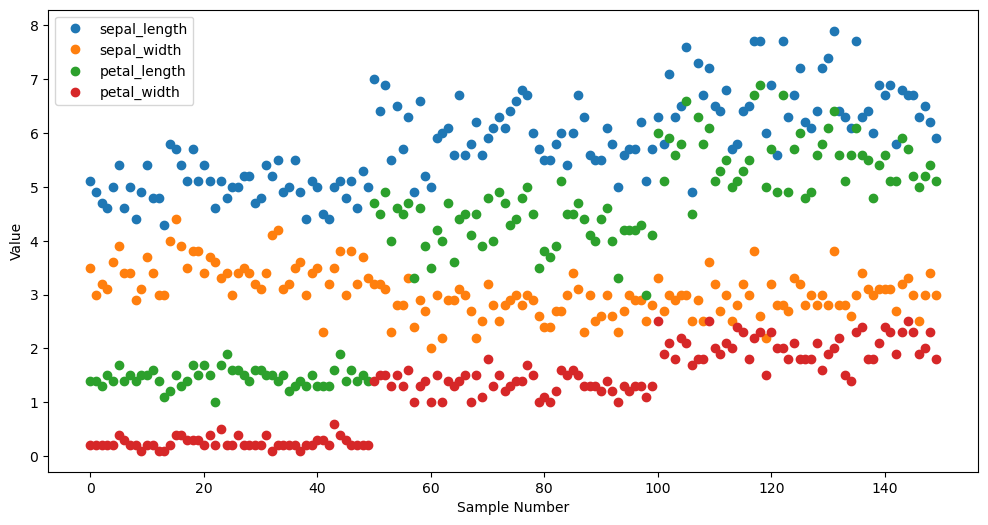

In [4]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.show()

In [6]:
# organize the data

# convert from opandas dataframe to tesor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to numbers
labels = torch.zeros(len(data),dtype=torch.long)
# labels[iris.species=='setosa'] =  # dont meed
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2

## Break the data into batches

In [12]:
# use scikitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1)

# then convert them into pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# finally translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
# check sizes of the data batches
for X,y in train_loader:
    print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

'''
The final matrix is of differnet size because we are not guranteed to 
have exactly the right no of samples in the data to fit in according to
this number of batches. So last bit of data ended up being 7 samples long.
'''

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


'\nThe final matrix is of differnet size because we are not guranteed to \nhave exactly the right no of samples in the data to fit in according to\nthis number of batches. So last bit of data ended up being 7 samples long.\n'

## Construct the model and training plans

In [15]:
# a function that creates the ANN model

def createANewModel():
    
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),     # input layer
        nn.ReLU(),           # activation unit
        nn.Linear(64,64),    # hidden layer
        nn.ReLU(),           # activation unit
        nn.Linear(64,3)      # output units
    )
    
    # loss function
    lossfun = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)
    
    return ANNiris,lossfun,optimizer

In [21]:
# train the model

# global parameter
numepochs= 500

def trainTheModel():
    
    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []
    
    # loop over epochs
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # compute training accuracy just for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # end of batch loop
        
        # now that we have trained through the batches, get their avg training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        # test accuracy
        X,y = next(iter(test_loader))  # extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
        
    # function output
    return trainAcc,testAcc,losses

## Test it out

In [22]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()

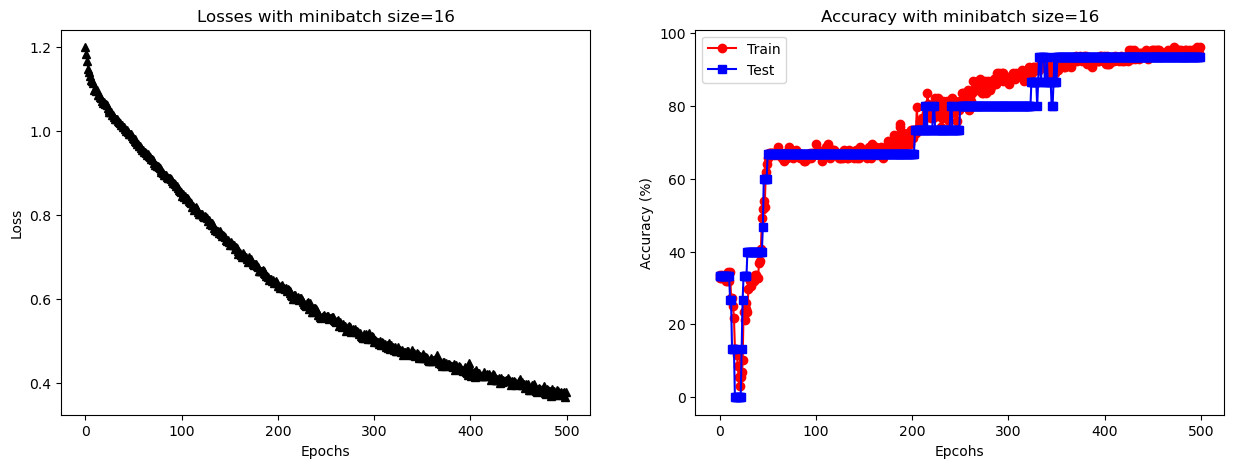

In [25]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epcohs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()